In [31]:
library("dplyr")
library("Seurat")
library("patchwork")
library("ggplot2")
library("clustree")

In [32]:
day0.data = Read10X(data.dir = "../Day0/filtered_feature_bc_matrix/")

day0_Seurat1 = CreateSeuratObject(counts = day0.data, project = "Day0", min.cells = 3, min.features = 2000)
print(day0_Seurat1)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
16822 features across 941 samples within 1 assay 
Active assay: RNA (16822 features, 0 variable features)
 1 layer present: counts


In [33]:
head(day0_Seurat1)

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACGCTGTGAGCAGT-1,Day0,7723,3117
AAAGAACCAGTACTAC-1,Day0,8648,3178
AAAGGATAGTGAGCCA-1,Day0,17152,4926
AAAGGATCACCTCTAC-1,Day0,4505,2020
AAAGGGCAGTGCGACA-1,Day0,6442,2375
AAAGGGCAGTGGACGT-1,Day0,4525,2062
AAAGGTATCGGAAGGT-1,Day0,7330,2766
AAAGTCCGTGATGTAA-1,Day0,4584,2081
AAAGTGACAGTCCGTG-1,Day0,12148,3018


### Add the percent of mitochondrial genes

In [34]:
# NOTE: only works when using LOWERCASE mt
day0_Seurat1[["percent.mt"]] = PercentageFeatureSet(day0_Seurat1, pattern = "^mt-")
head(day0_Seurat1)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACGCTGTGAGCAGT-1,Day0,7723,3117,3.845656
AAAGAACCAGTACTAC-1,Day0,8648,3178,3.364940
AAAGGATAGTGAGCCA-1,Day0,17152,4926,2.810168
AAAGGATCACCTCTAC-1,Day0,4505,2020,3.240844
AAAGGGCAGTGCGACA-1,Day0,6442,2375,1.133188
AAAGGGCAGTGGACGT-1,Day0,4525,2062,5.127072
AAAGGTATCGGAAGGT-1,Day0,7330,2766,1.909959
AAAGTCCGTGATGTAA-1,Day0,4584,2081,1.308901
AAAGTGACAGTCCGTG-1,Day0,12148,3018,3.161014


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


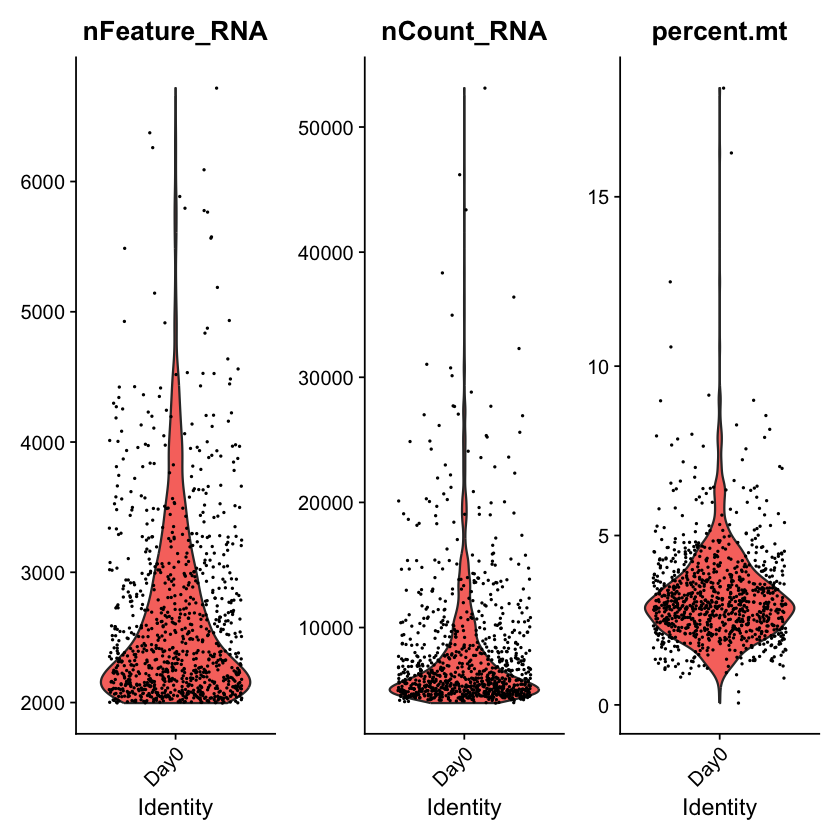

In [35]:
# Visualize QC metrics as a violin plot
# Start here to see the general trend of RNA and Counts
Vln_plots1 = VlnPlot(day0_Seurat1, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
print(Vln_plots1)

In [76]:
pdf(file = "Day0/figures/Day0_violin_plots.pdf",
    width = 10,
    height = 10)
print(Vln_plots1)
dev.off()

agg_record_1991548336 
                    2

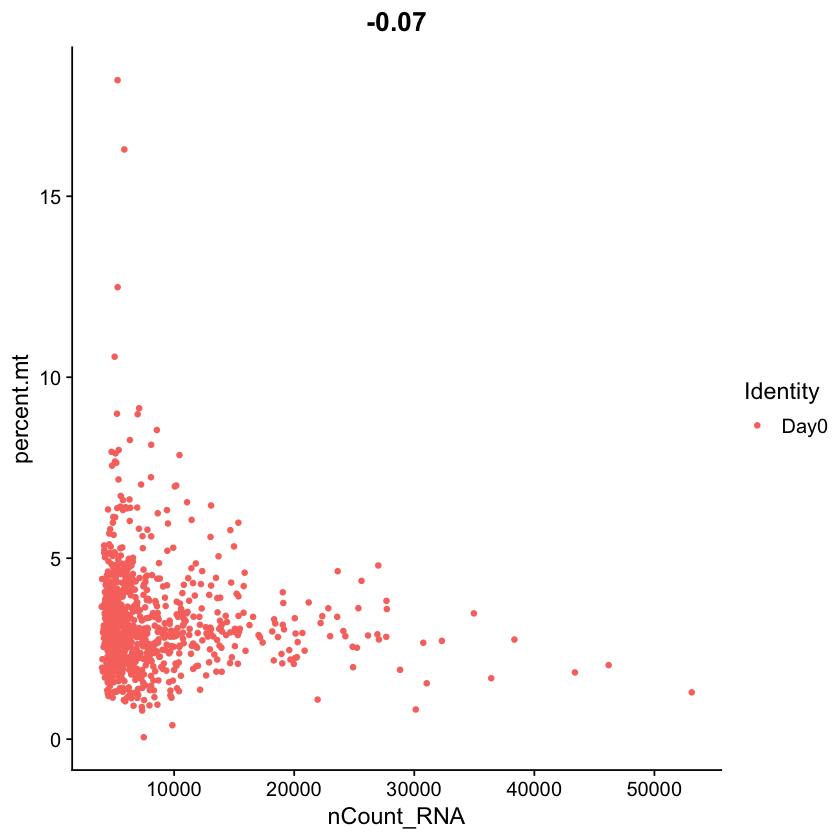

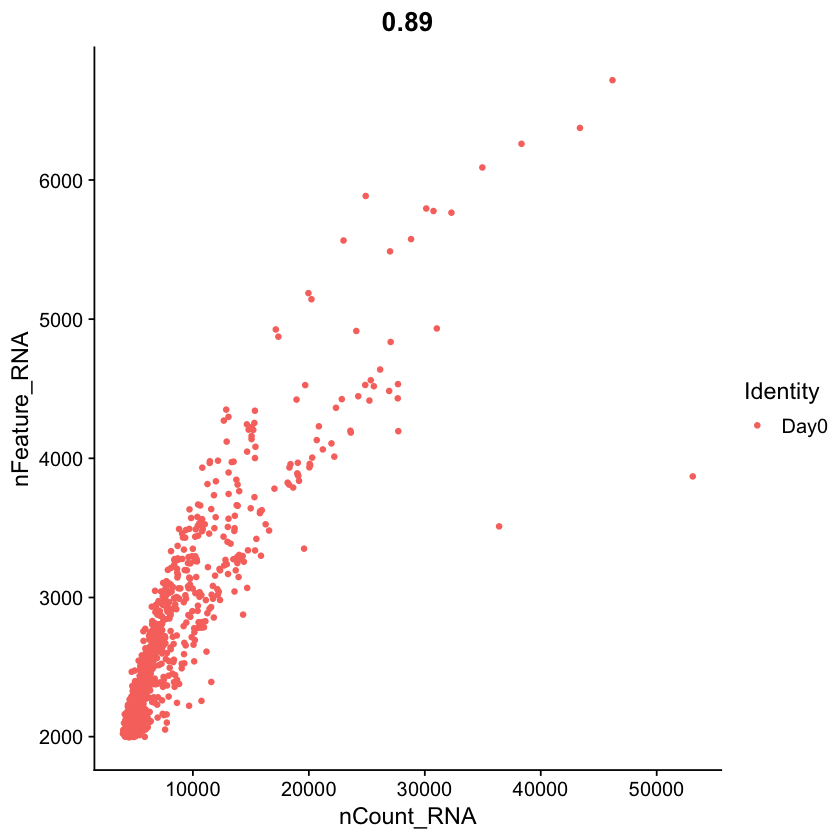

In [36]:
# FeatureScatter is typically used to visualize feature-feature 
# relationships, but can be used for anything calculated by the 
# object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(day0_Seurat1, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(day0_Seurat1, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
print(plot1)
print(plot2)

In [37]:
# Gather cells samples that have more than 200 genes and less than 5,000. 
# Anything less is most likely empty, anything higher than 5,000 most 
# likely contains more than one cell.
# Remove any cells that have more than 10 percent mitochondrial 
# counts as these are likely artifacts. Cell membrane is compromised 
# or mRNA leakage where only the mitochondrial mRNA remains
day0_Seurat2 <- subset(day0_Seurat1, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 10)

### Normalize the data

In [38]:
day0_Seurat3 = NormalizeData(object = day0_Seurat2, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



### Identification of highly variable features

Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


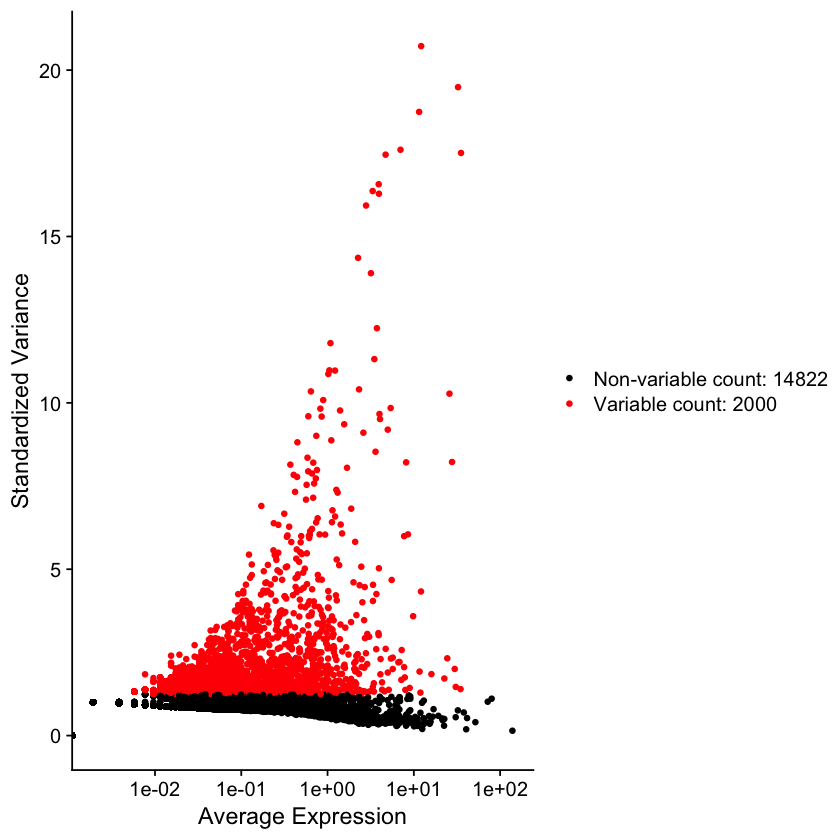

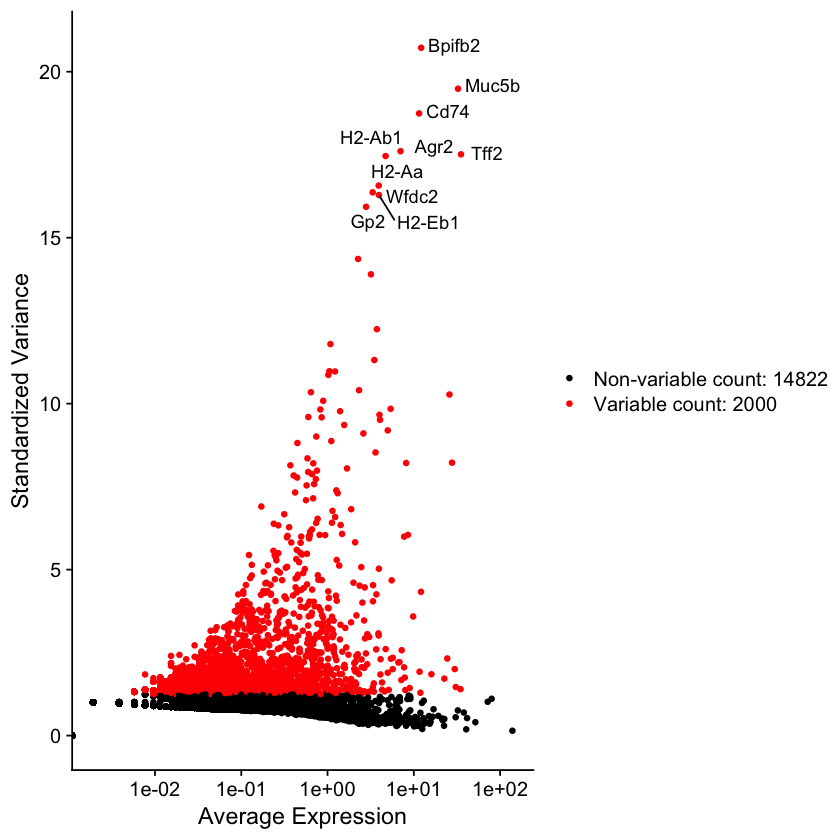

In [39]:
day0_Seurat3 = FindVariableFeatures(day0_Seurat3, selection.method = "vst", nfeatures = 2000)

#plot the top 10 features
top10 = head(VariableFeatures(day0_Seurat3),10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(day0_Seurat3)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
print(plot1)
print(plot2)

In [30]:
#save the top 10 VE genes with their p values
hvf_info = HVFInfo(day0_Seurat3)
top10_genes = head(VariableFeatures(day0_Seurat3), 10)

top10_df = hvf_info[top10_genes, ] %>%
                                  tibble::rownames_to_column(var = "gene")
print(top10_df)
write.csv(top10_df, file = "../Day0/results/top_10_VE_genes_day_0.csv", row.names = FALSE)

     gene      mean   variance variance.expected variance.standardized
1  Bpifb2 12.155470  3068.1046        118.324664              20.72132
2   Muc5b 32.535509 22028.1838        876.664564              19.48762
3    Cd74 11.510557  2501.7234        106.530479              18.74350
4    Agr2  7.005758  1060.7019         42.105967              17.60564
5    Tff2 35.224568 27566.3360       1039.514563              17.51029
6  H2-Ab1  4.706334   444.1271         20.755519              17.45869
7   H2-Aa  3.915547   305.0775         15.128241              16.56985
8   Wfdc2  3.332054   219.0415         11.527812              16.36484
9  H2-Eb1  3.940499   316.5753         15.292617              16.28438
10    Gp2  2.794626   173.1789          8.623168              15.93026


In [29]:
pdf(file = "../Day0/figures/Day0_top_10_VE_genes.pdf",
    width = 10,
    height = 10)
print(plot2)
dev.off()

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


agg_record_1210804428 
                    2

### Scaling the data

In [66]:
all.genes = rownames(day0_Seurat3)
day0_Seurat4 = ScaleData(day0_Seurat3, features = all.genes)

Centering and scaling data matrix



In [67]:
# Remove unwanted sources of variation from a single-cell dataset such as mitochondrial contamination.
day0_Seurat4 <- ScaleData(day0_Seurat4, vars.to.regress = "percent.mt")

Regressing out percent.mt

Centering and scaling data matrix

Warning message:
“Different features in new layer data than already exists for scale.data”


### Perform linear dimensional reduction

In [68]:
day0_Seurat5 = RunPCA(day0_Seurat4, features = VariableFeatures(object = day0_Seurat4))

PC_ 1 
Positive:  Ehd4, Cd93, Tspan13, Srgn, Pecam1, Egfl7, Cdh5, Tinagl1, Emcn, Ptprb 
	   Flt1, Ctla2a, Esam, Ecscr, Ucp2, Cd74, Cyyr1, Pcp4l1, Gimap6, F11r 
	   Bcam, Rasip1, H2-Eb1, H2-Ab1, Rnd1, Mmrn2, Apold1, Lcp1, Vwf, Gm8995 
Negative:  Col1a2, Col3a1, Col1a1, Serpinf1, Col6a1, Lum, Pcolce, Sparc, Fbln1, Mfap5 
	   Igfbp4, Postn, Il11ra1, Igfbp6, Htra1, Fn1, Rarres2, Ccdc80, Nbl1, Gas1 
	   Fbn1, Ctsk, Clec3b, Angptl1, Dpt, Col6a3, Bicc1, Aldh3a1, Spon2, Cd248 
PC_ 2 
Positive:  Tyrobp, Laptm5, Ctss, Ptprc, Spi1, Coro1a, Fcer1g, Alox5ap, Cd52, Cd53 
	   Ly86, Cd83, Aif1, H2-DMa, Slamf7, Lyz2, Clec4a2, Ptpn6, Cd300c2, Plek 
	   Ccr2, H2-DMb1, Cybb, Cd68, Lat2, Adgre1, Cytip, Pld4, Ccl9, Napsa 
Negative:  Pecam1, Cdh5, Tm4sf1, Pcp4l1, Emcn, Ecscr, Ptprb, Egfl7, Mmrn2, Cav1 
	   Esam, Cyyr1, Epas1, Adgrf5, Flt1, Rasip1, Sdpr, Apold1, Tinagl1, Plvap 
	   Rgs16, Rnd1, Eng, Ctla2a, Gimap6, Cd200, Hspb1, Abcg2, Gng11, Kdr 
PC_ 3 
Positive:  Lrrc26, Nkx3-1, Lman1l, Oit1, Wfdc2, Serpinb

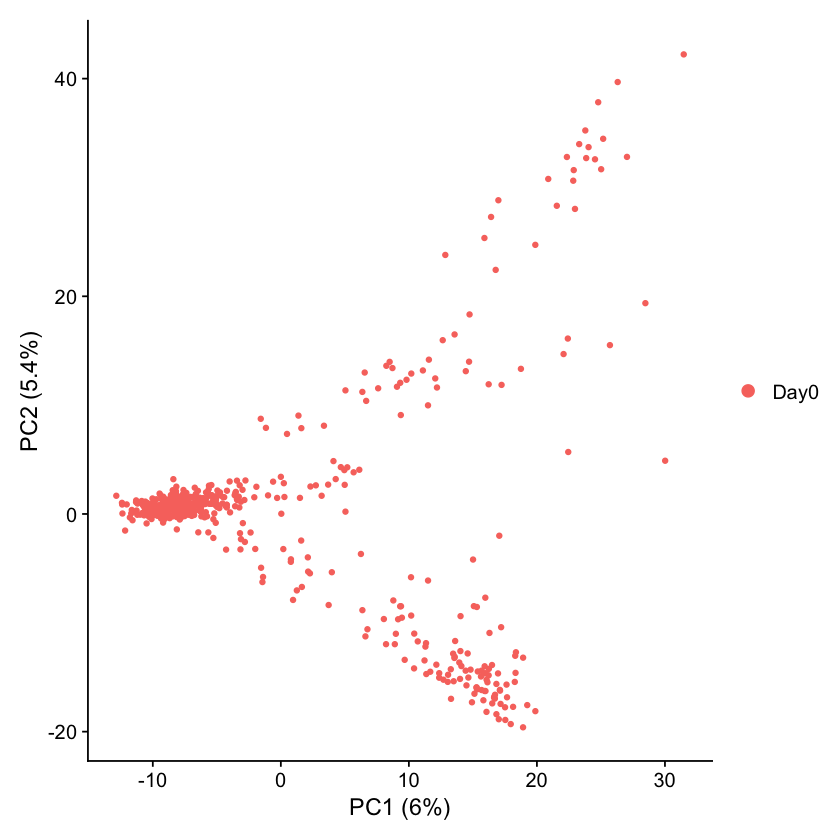

In [69]:
# To add the percent of variation explained by each component
pca_var <- Seurat::Stdev(object = day0_Seurat5, reduction = "pca")
pca_var_perc <- pca_var / sum(pca_var) * 100

pc1_perc <- round(pca_var_perc[1], 1)
pc2_perc <- round(pca_var_perc[2], 1)

PCA_plot1 = DimPlot(day0_Seurat5, reduction = "pca") +
                  xlab(paste0("PC1 (", round(pca_var_perc[1],1), "%)")) +
                  ylab(paste0("PC2 (", round(pca_var_perc[2],1), "%)"))
print(PCA_plot1)

In [70]:
pdf(file = "../Day0/figures/Day0_PCA.pdf",
    width = 10,
    height = 10)
print(PCA_plot1)
dev.off()

agg_record_96143414 
                  2

### Determine the dimensionality of the dataset

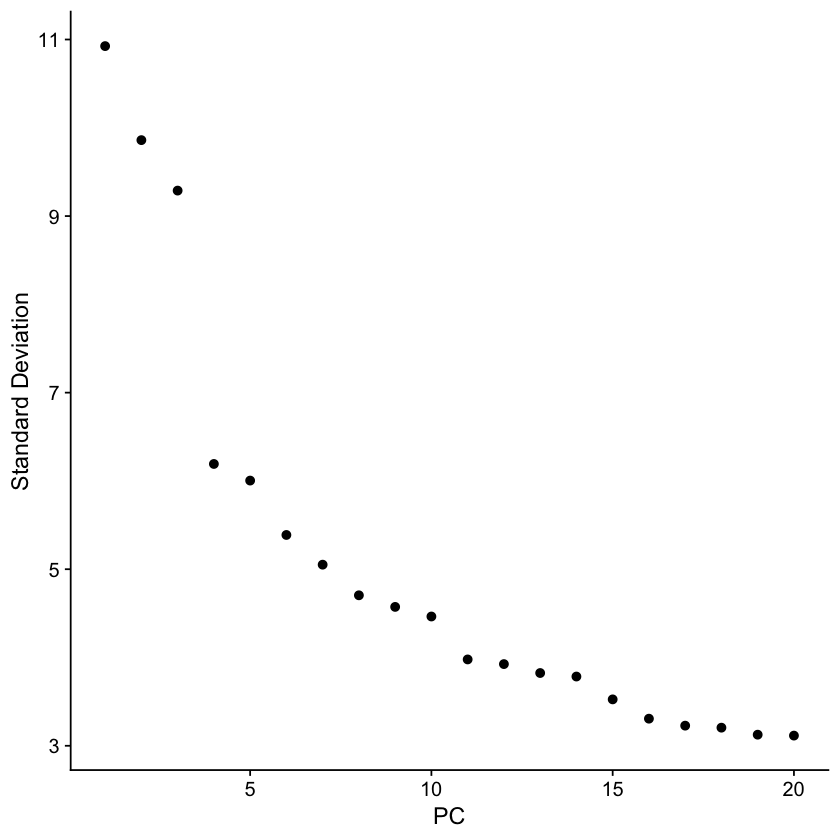

In [44]:
ElbowPlot(day0_Seurat5)

### Cluster the cells

In [61]:
#resolution
# Value of the resolution parameter, use a value above (below) 
# 1.0 if you want to obtain a larger (smaller) number of communities.
day0_Seurat5 = FindNeighbors(day0_Seurat5, dims = 1:50)
day0_Seurat5 = FindClusters(day0_Seurat5, resolution = c(0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 521
Number of edges: 16451

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9172
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 521
Number of edges: 16451

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8564
Number of communities: 6
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 521
Number of edges: 16451

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8170
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 521
Number of edges: 16451

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7849
Number of communities: 8
Elapsed time: 0 seconds
Modularity Optimizer version

In [54]:
head(Idents(day0_Seurat5), 5)

AAAGGATCACCTCTAC-1 AAAGGGCAGTGCGACA-1 AAAGGGCAGTGGACGT-1 AAAGTCCGTGATGTAA-1 
                 3                  1                  3                  1 
AACACACGTTTCAGAC-1 
                 1 
Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12

### Run non-linear dimensional reduction, UMAP

In [62]:
day0_Seurat5 = RunUMAP(day0_Seurat5, dims = 1:50)

10:27:09 UMAP embedding parameters a = 0.9922 b = 1.112

10:27:09 Read 521 rows and found 50 numeric columns

10:27:09 Using Annoy for neighbor search, n_neighbors = 30

10:27:09 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:27:09 Writing NN index file to temp file /var/folders/t9/tm6czqy15131vrjm3_cwgw9h0000gp/T//RtmpapHjk1/file7862de375e9

10:27:09 Searching Annoy index using 1 thread, search_k = 3000

10:27:09 Annoy recall = 100%

10:27:09 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

10:27:10 Initializing from normalized Laplacian + noise (using RSpectra)

10:27:10 Commencing optimization for 500 epochs, with 19308 positive edges

10:27:10 Using rng type: pcg

10:27:10 Optimization finished



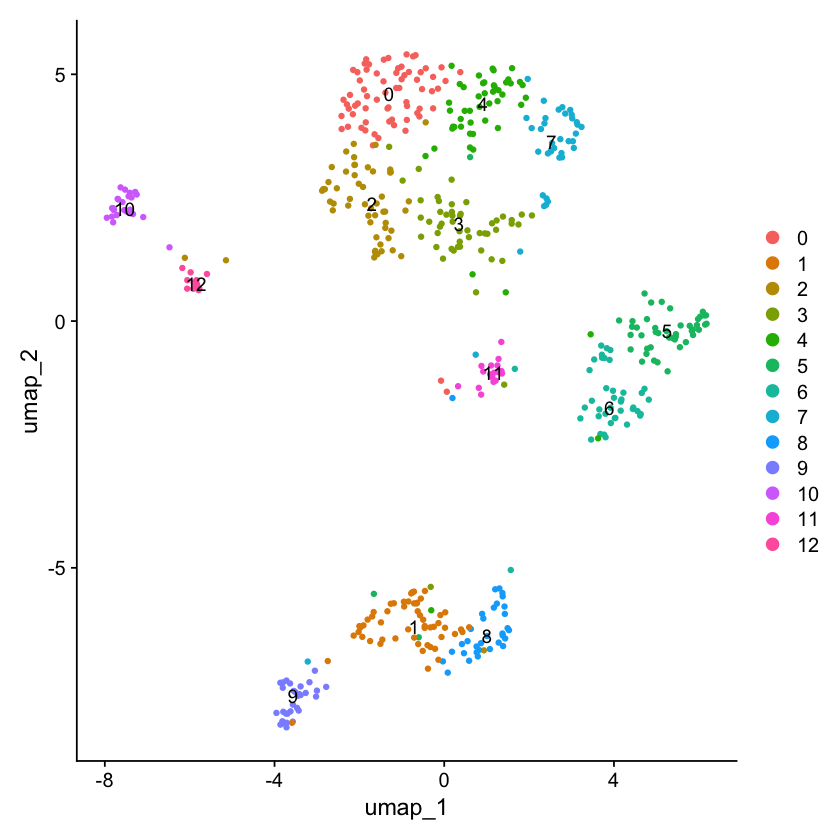

In [63]:
UMAP_plot1 = DimPlot(day0_Seurat5, reduction = "umap", label = TRUE)
print(UMAP_plot1)

In [60]:
pdf(file = "../Day0/figures/Day0_UMAP_plot.pdf",
    width = 10,
    height = 10)
print(UMAP_plot1)
dev.off()

agg_record_35380399 
                  2

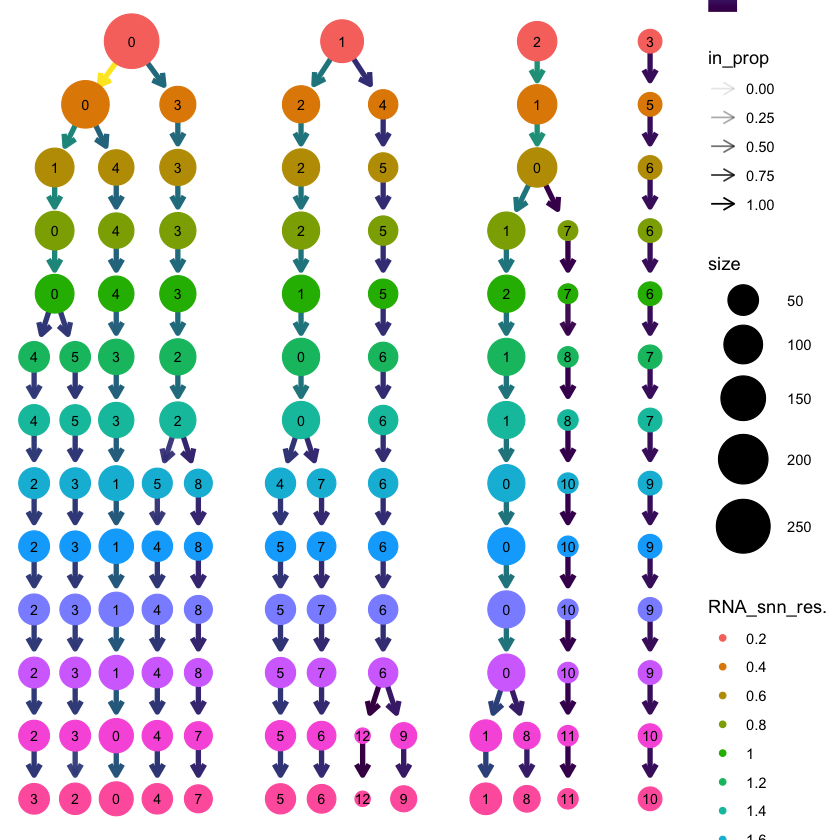

In [64]:
phylo_tree1 = clustree(day0_Seurat5, prefix = "RNA_snn_res.")
print(phylo_tree1)

In FindClusters(), resolution controls how finely the shared-nearest-neighbor (SNN) graph is cut:<br>
lower resolution → fewer, larger clusters<br>
higher resolution → more, smaller clusters<br>
Each column in clustree is a resolution. Each node is a cluster at that resolution.

In [65]:
pdf(file = "../Day0/figures/Day0_phylogenetic_tree.pdf",
    width = 10,
    height = 10)
print(phylo_tree1)
dev.off()

agg_record_1459196243 
                    2

In [25]:
sessionInfo()

R version 4.5.1 (2025-06-13)
Platform: aarch64-apple-darwin20
Running under: macOS Tahoe 26.0.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.1

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Chicago
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] future_1.68.0      clustree_0.5.1     ggraph_2.2.2       ggplot2_4.0.1     
[5] patchwork_1.3.2    Seurat_5.4.0       SeuratObject_5.3.0 sp_2.2-0          
[9] dplyr_1.1.4       

loaded via a namespace (and not attached):
  [1] RColorBrewer_1.1-3     jsonlite_2.0.0         magrittr_2.0.4        
  [4] spatstat.utils_3.2-0   farver_2.1.2           ragg_1.5.0            
  [7] vctrs_0.6.5            ROCR_1.0-11    